# Analysis of outwardly depressive modd on social media

Use of Natural Language Processing on posts made on Twitter and Reddit to predict depressive thoughts.

---

This notebook is written to be run both locally or on Google Colab.

## Setup for local run

- Download the root file as is.
- Install packages

In [ ]:
# ! pip install -r requirements.txt

## Setup for Google Colab

- Download this notebook and upload onto Google Colab
- Download the zip files (within /input) and upload into root directory of your Google Drive.

*You may download the [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) directly from the source and replace the provided one (within /input). No edits were made to the data.*

In [35]:
import pandas as pd
import numpy as np
import nltk
import pickle

from re import sub
from time import time

nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models.word2vec import Word2Vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dropout, CuDNNLSTM, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from matplotlib.pyplot import show, subplots

from tqdm import tqdm
from tqdm.keras import TqdmCallback
tqdm.pandas()

from dask.diagnostics import ProgressBar
import dask.dataframe as dd
ProgressBar().register()

import random
from datetime import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JunKai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def runLocally():

    import shutil
    import os
    import tensorflow as tf

    print("Running locally...")

    path = './build'

    if not os.path.isdir(path):
        for x in os.listdir('./input'):
            shutil.unpack_archive(f'./input/{x}', path)
            print(f"Extracted {x} into '{path}' directory")
    else:
        print(f"{path} directory already exists. Skipping extracting of zip files.")

    gpuCount = len(tf.config.list_physical_devices('GPU'))
    
    if gpuCount > 0:

        print(f"{gpuCount} GPUs detected.")

        if tf.test.is_built_with_cuda():
            print(f"Tensorflow has CUDA support.")

        if not tf.test.is_built_with_cuda():
            print("Tensorflow doesn't have CUDA support.")
    else:
        print("No GPUs detected on local device.")

    return path

def runOnColab():

    from google.colab import drive
    
    print("Running on Google Colab")
    
    drive.mount('/content/drive')

    !unzip "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv.zip"
    !unzip "/content/drive/MyDrive/scrapped_posts.zip"

    return '/content'
    
directory = runLocally()

Running locally...
./build directory already exists. Skipping extracting of zip files.
1 GPUs detected.
Tensorflow has CUDA support.


# **Loading data**

We are using 2 sources of data, pre-catagorised twitter posts from kaggle, and scrapped reddit post from specific subreddits.

1. Twitter Posts from Kaggle

2. Scrape posts from subreddits; [/r/depression](https://www.reddit.com/r/depression/), [/r/suicidewatch](https://www.reddit.com/r/SuicideWatch/)

This is to allow for a greater vocabulary between the two different websites for more general NLP.

---

## Twitter data from [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140)

In [4]:
df1 = pd.read_csv(f'{directory}/training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)
df1.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df1.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


---

## Reddit data from scrapper

*Below is a code block of the scrapping code we ran ahead of time. The raw data was exported to csv files and zipped into /input/scrapped_posts.zip as it tooks hours to scrapped the data and there were limitations with the api used.*

*Note: Since last touched, the api endpoints may have changed.*

In [5]:
df2 = pd.read_csv(f"{directory}/depression.csv")
df3 = pd.read_csv(f"{directory}/suicide_watch.csv")

df2.head()

,Post_iD,Title,Author,Body,Score,Total_no_of_comments,Publish_date,Subreddit,Link
0,s933xe,Confused,Ciscobudd,My depression has crept up on me today. I feel...,1,0,2022-01-21 13:17:11,depression,https://www.reddit.com/r/depression/comments/s...
1,s935jy,Broken,Bazinga_yo_ass,Wife said she doesn't feel anything for me any...,1,0,2022-01-21 13:20:08,depression,https://www.reddit.com/r/depression/comments/s...
2,s935r4,Nothing feels fun anymore,Sad_Mode6170,"I used to enjoy a lot of things, like drawing,...",1,0,2022-01-21 13:20:25,depression,https://www.reddit.com/r/depression/comments/s...
3,s939jq,I only think about suicide,b2me75,I started doing it because it was the only thi...,1,0,2022-01-21 13:26:30,depression,https://www.reddit.com/r/depression/comments/s...
4,s939xc,Haven’t done anything in 3 weeks,Tall-Half-8363,I was assaulted at a New Years Eve party. \n\n...,1,0,2022-01-21 13:27:08,depression,https://www.reddit.com/r/depression/comments/s...


---

# Merging data twitter-reddit

- Standardise twitter columns
  - Drop excess columns
- Standardise reddit columns to twitter columns
  - Remove invalid posts and users ~ Users and posts may be deleted or removed
  - Rename columns
  - Merge title and body (reddit posts) into body ~ twitter posts don't have titles
  - Drop excess columns
- Assign sentiment score based on subreddit pulled from
- Merge into single dataframe

*Assume posts from same subreddit have similar sentiment score; posts from [/r/depression](https://www.reddit.com/r/depression/), [/r/suicidewatch](https://www.reddit.com/r/SuicideWatch/) are negative.*

*The size of twitter data from [Sentiment140](https://www.kaggle.com/datasets/kazanova/sentiment140) far exceeds that of reddit data, so this assumption does not effect the data much.*

In [6]:
df1 = df1.drop(columns=['query'])
df1.head()

,sentiment,id,date,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
def removeInvalidRedditPost(df):
    df = df[df.Body.notna()]
    df = df[df.Author != "[removed]"]
    df = df[df.Body != "[removed]"]
    df = df[df.Author != "[deleted]"]
    df = df[df.Body != "[deleted]"]

    return df

def standardiseRedditDF(dff, sentimentValue=None):

    dff = removeInvalidRedditPost(dff)
    dff.rename(columns={'Author': 'user_id', 'Post_iD': 'id', 'Publish_date':'date', 'Body':'text'}, inplace=True)
    dff['text'] = dff['Title'].str.cat(dff['text'], sep=" ")
    dff = dff.drop(columns=['Score', 'Total_no_of_comments', 'Link', 'Subreddit', 'Title'])
    
    if sentimentValue != None:
        dff['sentiment'] = sentimentValue

    return dff

df2 = standardiseRedditDF(df2, 0)
df3 = standardiseRedditDF(df3, 0)

df2.head()

In [8]:
df = pd.concat([df1, df2, df3])

df.sample(10)

,sentiment,id,date,user_id,text
14926,0,sedp6o,2022-01-28 08:48:01,irnwlf11183,Never posted here before. Finally talked to my...
91,0,1467835577,Mon Apr 06 22:26:14 PDT 2009,viviana09,wednesday my b-day! don't know what 2 do!!
1562159,4,2186765695,Mon Jun 15 19:18:18 PDT 2009,jamieleecm,@michaelyap sure u can read those! come on! We...
635065,0,2233503649,Thu Jun 18 21:27:22 PDT 2009,aidiebravo,@MLucasClouser ......I went to Target! Hahaha!...
723077,0,2261684336,Sat Jun 20 21:10:44 PDT 2009,Baby_Bela,got a much better response from my dad than I ...
30164,0,1563693358,Sun Apr 19 23:51:18 PDT 2009,PaigeDryhurst,Headache
571947,0,2209079682,Wed Jun 17 09:59:08 PDT 2009,applevampires,@sophiaxxxx i couldn't get a ticket plus i wa...
406822,0,2059022152,Sat Jun 06 16:05:33 PDT 2009,Nikolski,Mmmm sooooooo whats good tonight? I want to go...
1564516,4,2187322867,Mon Jun 15 20:06:49 PDT 2009,karigeha,Vent session with Ian.
97374,0,1792952379,Thu May 14 00:49:26 PDT 2009,thomasshaw,@marktee damm. not going to say the phrase. y...


# Prepping data

## Mapping sentiments

* 0 - negative
* 2 - neutral
* 4 - positive



In [9]:
def sentimentMapping(label):
    decodeMap = {0: "Negative", 2: "Neutral", 4: "Positive"}
    return decodeMap[int(label)]

df.sentiment = df.sentiment.progress_map(lambda x: sentimentMapping(x))

100%|██████████| 1805346/1805346 [00:03<00:00, 557638.30it/s]


## Cleaning text

1. Lower casing
2. Replacing URLs
3. Replacing username references 
4. Removing non-alphanumerics
5. Removing stopwords

In [5]:
def preprocess(text):
  
    text = str(text).lower()
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = "@[^\s]+" 
    alphaPattern      = "[^a-zA-Z0-9]"

    text = sub(urlPattern, ' URL', text).strip()
    text = sub(userPattern, ' USER', text).strip()
    text = sub(alphaPattern, ' ', text).strip()
    
    stopWords = stopwords.words("english")
    tokens = list(filter(lambda x: x not in stopWords, text.split()))

    return " ".join(tokens)

def parellelPreProcess(df):
    ddf = dd.from_pandas(df, npartitions=4)
    ddf["text"] = ddf["text"].map(lambda x: preprocess(x), meta=('result', str))
    return ddf.compute()

df = parellelPreProcess(df)

## Cleaned and merged data

In [30]:
df.sample(10)

,sentiment,id,date,user_id,text
1036116,Positive,1956293430,Thu May 28 21:34:22 PDT 2009,the_1prince,kno twittered min busy day sttil gettin used t...
1320798,Positive,2014623619,Wed Jun 03 02:08:37 PDT 2009,Funky_Junk,USER erm yeah idea guessing
820750,Positive,1553832893,Sat Apr 18 15:20:02 PDT 2009,HotPinkNikes,strum like guitar blow amplifier
1434384,Positive,2060616874,Sat Jun 06 19:14:38 PDT 2009,smharley,oh USER
405988,Negative,2058824250,Sat Jun 06 15:42:01 PDT 2009,susanbeebe,USER yes many levels
1366089,Positive,2050079727,Fri Jun 05 18:01:47 PDT 2009,irenezhang,proud USER decision water congratulation
768480,Negative,2301017293,Tue Jun 23 14:53:31 PDT 2009,karlaisfresh,ugh get five something thursday
437490,Negative,2065936741,Sun Jun 07 09:34:45 PDT 2009,Closson,USER going site bunch desktop web apps lot 140...
1512748,Positive,2175262965,Mon Jun 15 00:30:44 PDT 2009,leigh_suhBBY,looking frens twitter
1056470,Positive,1962486250,Fri May 29 11:07:12 PDT 2009,Bvittu,crazy woohoo found pur pitch


# Creating the model

## Train and test splitting

80/20 split

In [ ]:
trainData, testData = train_test_split(df, train_size=0.8)

print("Train size:", len(trainData))
print("Test size:", len(testData))

## Tokenisation

In [ ]:
tokeniser = Tokenizer()
tokeniser.fit_on_texts(trainData.text)

vocabSize = len(tokeniser.word_index) + 1
print(f'Vocab size: {vocabSize}')

## Encoder

In [ ]:
%%time

encoder = LabelEncoder()
encoder.fit(trainData.sentiment.to_list())

## Reshaping train and test variables

In [ ]:
%%time

xTrain = pad_sequences(tokeniser.texts_to_sequences(trainData.text), maxlen = 300)
xTest = pad_sequences(tokeniser.texts_to_sequences(testData.text), maxlen = 300)

yTrain = encoder.transform(trainData.sentiment.to_list()).reshape(-1,1)
yTest = encoder.transform(testData.sentiment.to_list()).reshape(-1,1)

## Model build

In [ ]:
%%time

w2vModel = Word2Vec(vector_size=300, window=7, min_count=10, workers=6)

_words = [_text.split() for _text in trainData.text]

w2vModel.build_vocab(_words)
w2vModel.train(tqdm(_words), 
                total_examples=len(_words), 
                epochs=8,
              )

embMatrix = np.zeros((vocabSize, 300))
for word, i in tqdm(tokeniser.word_index.items()):
  if word in w2vModel.wv:
    embMatrix[i] = w2vModel.wv[word]

embLayer = Embedding(vocabSize, 300, weights=[embMatrix], input_length=300, trainable=False)

In [ ]:
model = Sequential()
model.add(embLayer)
model.add(Dropout(0.5))
model.add(CuDNNLSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
%%time

model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
%%time
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0), 
              EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
              TqdmCallback(verbose=2)
            ]

history = model.fit(xTrain, yTrain,
                    batch_size=1024,
                    epochs=8,
                    validation_split=0.1,
                    verbose=0,
                    callbacks=callbacks)

# Saving and loading model

This function is to save a trained model and load a pre-trained model from model.h5. To use place 'model.h5' file within


In [6]:
def saveModel():
    model.save("model.h5")
    pickle.dump(tokeniser, open("tokenizer.pkl", "wb"), protocol=0)

def loadModel(pathToModel, pathToPKL):
    with open(pathToPKL, 'rb') as f:
        tokeniser = pickle.load(f)
    return load_model(pathToModel), tokeniser

# Example usage
# model, tokeniser = loadModel("./model.h5", "./tokenizer.pkl")
# saveModel()

# Analysis

In [7]:
def sentimentFromScore(score):
  score = float(score)
  label = 'Neutral'
  if score <= 0.35:
      label = 'Negative'
  elif score >= 0.65:
      label = 'Positive'

  return label

def predict(text, wantsTime=False):
  if wantsTime: 
      start_at = time()
  
  text = str(text)
  score = model.predict(pad_sequences(tokeniser.texts_to_sequences([text]), maxlen=300))

  result = {"label": sentimentFromScore(score), 
            "score": score}
  
  if wantsTime: 
      result["elapsedTime"] = time() - start_at

  return result

# prediction = predict("I'm sick of this game", True)

# print(f"Label: {prediction['label']}")
# print(f"Score: {prediction['score']}")
# print(f"Time elapsed: {prediction['elapsedTime']}s")

Label: Negative
Score: [[0.01387025]]
Time elapsed: 3.8083529472351074s


## Preparing data from uncategorised subreddits

In [60]:
def processSubreddit(file, count = 0):
    df4 = pd.read_csv(f"{directory}/{file}")
    df4 = standardiseRedditDF(df4)
    df4 = parellelPreProcess(df4)

    if count > 0:
        df4 = df4.head(count)
        
    ddf = dd.from_pandas(df4, npartitions=4)
    ddf["sentimentScore"] = ddf["text"].map(lambda x: float(predict(x)['score']), meta=('result', float))
    ddf["sentiment"] = ddf["sentimentScore"].map(lambda x: sentimentFromScore(x), meta=('result', str))
    df4 = ddf.compute()
    
    return df4
    
teenagersDF = processSubreddit('teenagers.csv', 4000)
teenagersDF.head()

[########################################] | 100% Completed | 15.9s
[########################################] | 100% Completed | 16.0s
[########################################] | 100% Completed |  1min 51.8s
[########################################] | 100% Completed |  1min 51.9s


,id,user_id,text,date,sentimentScore,sentiment
1,tif34g,SnooCrickets5781,bruh people push death penalty women got abort...,2022-03-20 06:37:17,0.127721,Negative
2,tif2xz,Axehead-245,wish felt loved cut feel better trigger warnin...,2022-03-20 06:36:55,0.000078,Negative
4,tif2p3,AutisticOutlaw,girls boys ask enby answer non binary version ...,2022-03-20 06:36:23,0.736521,Positive
8,tif1mi,el-chapin-supreme,comment letter give song starting letter x q z...,2022-03-20 06:34:11,0.823892,Positive
10,tif151,Gigachad-1,boys guess day today chest day,2022-03-20 06:33:14,0.245856,Negative


In [61]:
def duplicatePosts(df):
    
    duplicatePosts = df.groupby('user_id').filter(lambda x : x['user_id'].shape[0]>=3)

    return duplicatePosts

duplicatePostsTeenagersDF = duplicatePosts(teenagersDF)
duplicatePostsTeenagersDF.count()

id                1860
user_id           1860
text              1860
date              1860
sentimentScore    1860
sentiment         1860
dtype: int64

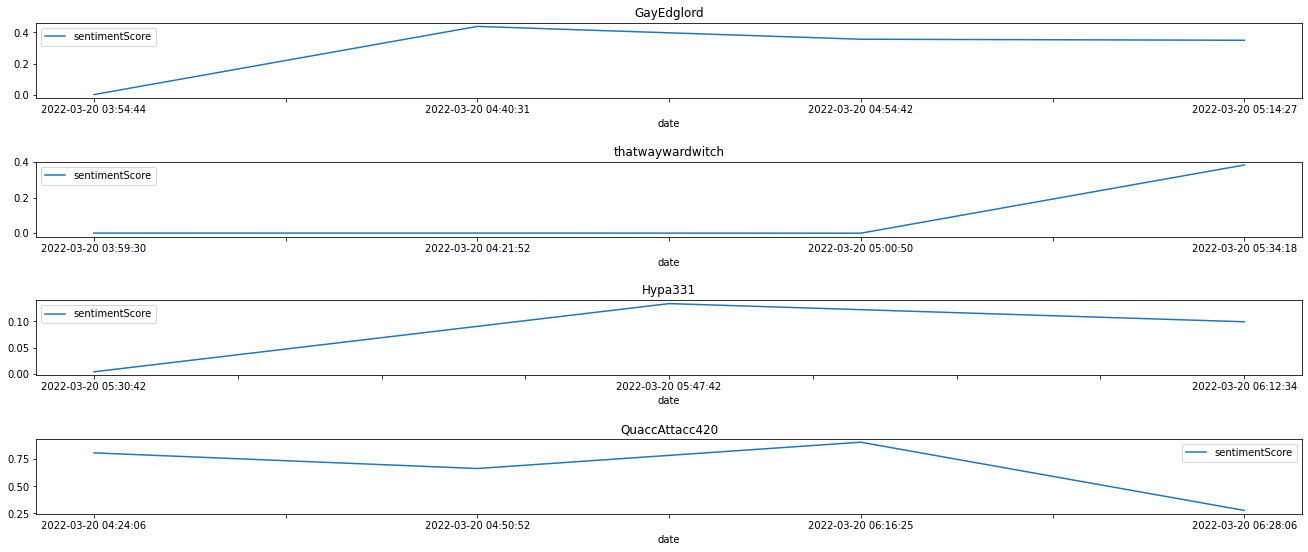

In [12]:
def sampleFromDupDf(df, count):
    
    fig, axs = subplots(count)
    fig.tight_layout()
    
    names = df.user_id.unique()
    random.shuffle(names)
    
    for index, name in enumerate(names[0:count]):
        tina = df[df["user_id"] == name].sort_values("date")
        tina.plot(x='date', y='sentimentScore', kind='line', figsize=(20,8), ax=axs[index])
        axs[index].set_title(f"{name}")
        
    show()

sampleFromDupDf(duplicatePostsTeenagersDF, 4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


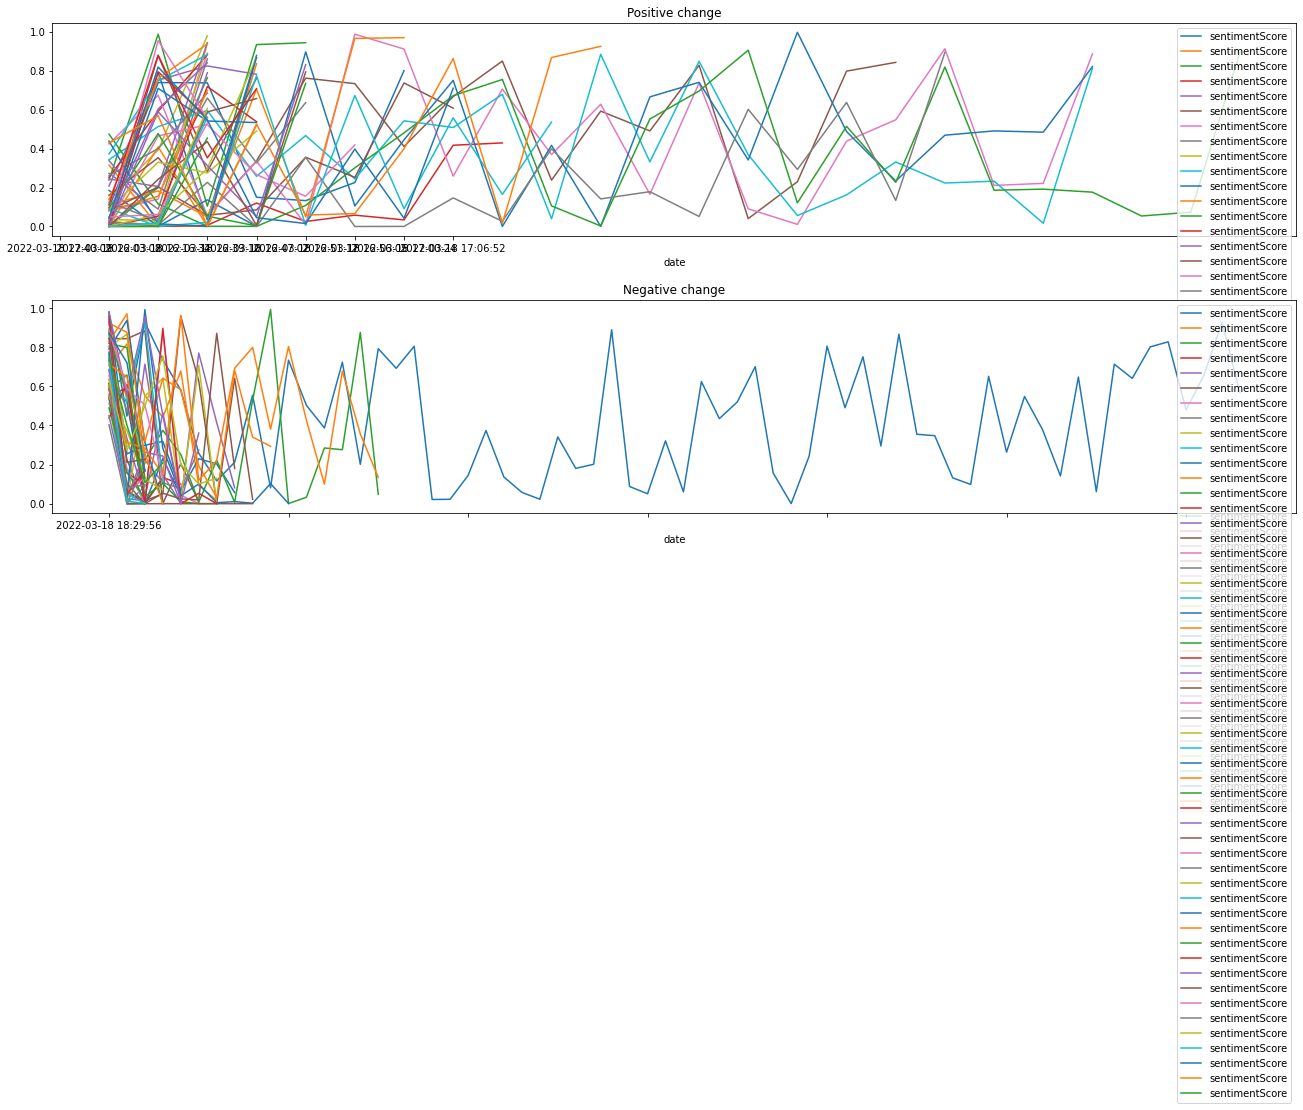

In [62]:
significantDiff = 0.4

def hello(df, subset = 0):
    
    fig, axs = subplots(2)
    fig.tight_layout()

    axs[0].set_title(f"Positive change")
    axs[0].legend().set_visible(False)
    axs[1].set_title(f"Negative change")
    axs[1].legend().set_visible(False)
    
    names = df.user_id.unique()
    
    if subset > 0:
        random.shuffle(names)
        names = names[0:subset]
    
    for name in names:
        tina = df[df["user_id"] == name].sort_values("date")

        diff = tina['sentimentScore'].iat[-1] - tina['sentimentScore'].iat[0]

        if diff >= significantDiff:
            tina.plot(x='date', y='sentimentScore', kind='line', figsize=(20,8), ax=axs[0])
        elif diff <= -significantDiff:
            tina.plot(x='date', y='sentimentScore', kind='line', figsize=(20,8), ax=axs[1])
        
    show()

hello(duplicatePostsTeenagersDF)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


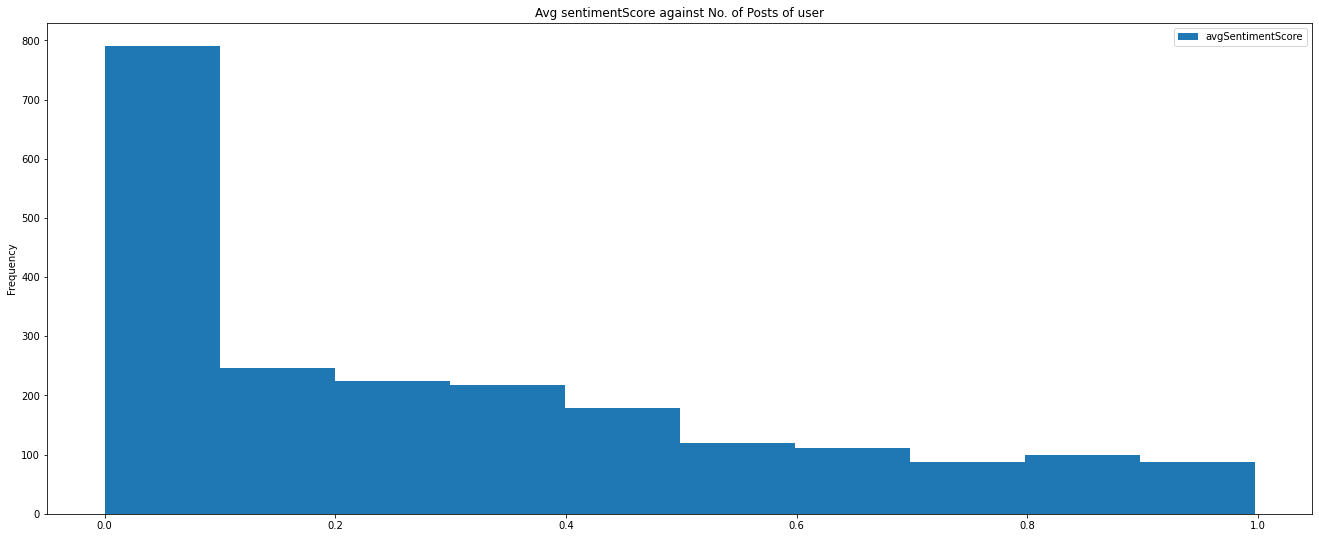

In [80]:
significantDiff = 0.4

def hello(df, subset=0):
    
    fig, axs = subplots(1)
    fig.tight_layout()

    axs.set_title(f"Avg sentimentScore against No. of Posts of user")
    axs.legend().set_visible(False)
    
    tempdf = pd.DataFrame()

    names = df.user_id.unique()

    if subset > 0:
        random.shuffle(names)
        names = names[0:subset]
    
    tempdf['user_id'] = pd.DataFrame(names)
    
    tempListMean = []
    tempListCount = []

    for name in names:
        tempListMean.append(df[df['user_id'] == name]['sentimentScore'].mean())
        tempListCount.append(len(df[df['user_id'] == name].index))
    
    tempdf['avgSentimentScore'] = pd.DataFrame(tempListMean)
    tempdf['postFreq'] = pd.DataFrame(tempListCount)
    
    tempdf.plot(x='postFreq', y='avgSentimentScore', kind='hist', figsize=(20,8), ax=axs)
        
    show()

    return tempdf

heyo = hello(teenagersDF)

In [81]:
heyo.sample(50)

,user_id,avgSentimentScore,postFreq
2096,Wiriwi_Seco,0.639880,1
465,_Turtle_Chan,0.913597,1
43,swyb-doo,0.641957,5
1296,hheh92989922bxbee,0.000377,1
1893,Splatstab,0.932371,1
738,heroblade123,0.372447,2
853,Particular_Team5675,0.023321,1
1878,x_obert,0.260677,1
2118,Idkoro,0.036320,1
106,premierechatpro,0.007037,1
